# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor


In [2]:
# Load the dataset
file_path = 'data/vehicles.csv'  
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("First few entries of the dataset:")
print(data.head())

# Display the dataset's structure and data types
print("\nData Types and Missing Values:")
print(data.info())

# Summary statistics for numerical features
print("\nSummary Statistics for Numerical Features:")
print(data.describe())

# Summary statistics for categorical features
print("\nSummary Statistics for Categorical Features:")
print(data.describe(include=['O']))  # 'O' indicates Python objects, typically strings for categorical data

# Check for missing values
print("\nMissing Values in the Dataset:")
print(data.isnull().sum())



First few entries of the dataset:
           id                  region  price  year manufacturer model  \
0  7222695916                prescott   6000   NaN          NaN   NaN   
1  7218891961            fayetteville  11900   NaN          NaN   NaN   
2  7221797935            florida keys  21000   NaN          NaN   NaN   
3  7222270760  worcester / central MA   1500   NaN          NaN   NaN   
4  7210384030              greensboro   4900   NaN          NaN   NaN   

  condition cylinders fuel  odometer title_status transmission  VIN drive  \
0       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
1       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
2       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
3       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
4       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   

  size type paint_color state  
0  NaN  NaN         NaN    az  


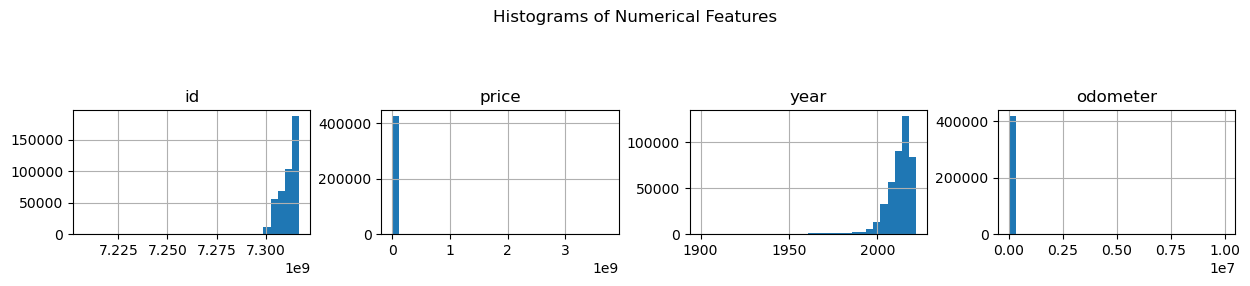


Boxplots for Numerical Features:


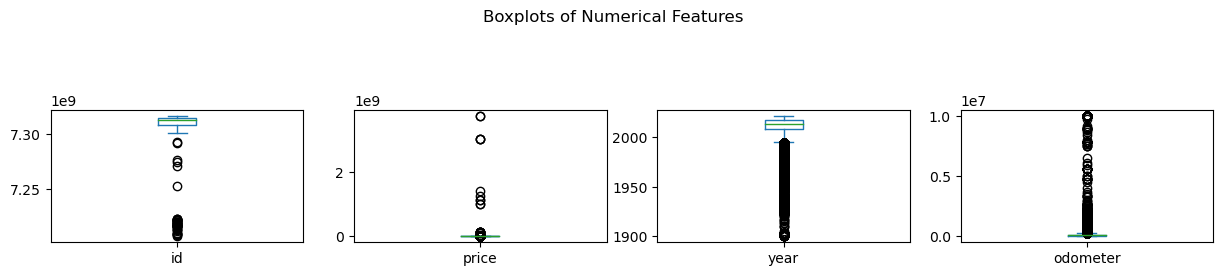

In [3]:
# Histograms for all numerical features
data.hist(bins=30, figsize=(15, 10), layout=(5, 4))  # Adjust layout depending on the number of numerical features
plt.suptitle('Histograms of Numerical Features')
plt.show()

# Boxplots for numerical features to check for outliers
print("\nBoxplots for Numerical Features:")
data.plot(kind='box', subplots=True, layout=(5, 4), figsize=(15, 10), sharex=False, sharey=False)  # Adjust layout
plt.suptitle('Boxplots of Numerical Features')
plt.show()


### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [4]:
relevant_columns = ['price', 'region', 'year', 'model', 'condition', 'cylinders', 
                    'fuel', 'odometer', 'drive', 'size', 'type', 'paint_color', 'state']
data.dropna(subset=relevant_columns, inplace=True)

# Filter out outlier prices and odometer readings based on quantiles
price_threshold_low = data['price'].quantile(0.01)
price_threshold_high = data['price'].quantile(0.99)
odometer_threshold_high = data['odometer'].quantile(0.99)
data = data[(data['price'] > price_threshold_low) & 
            (data['price'] < price_threshold_high) & 
            (data['odometer'] < odometer_threshold_high)]

# Calculate Pearson correlation for numerical features
numerical_features = ['year', 'odometer']
correlations = data[numerical_features + ['price']].corr()['price'].drop('price')

# ANOVA for each categorical feature
anova_results = {}
categorical_features = ['region', 'model', 'condition', 'cylinders', 'fuel', 
                        'drive', 'size', 'type', 'paint_color', 'state']

for feature in categorical_features:
    groups = data.groupby(feature)['price'].apply(list)
    f_statistic, p_value = f_oneway(*groups)
    anova_results[feature] = (f_statistic, p_value)

# Sorting features by relevance:
# Numerical features sorted by the absolute value of the correlation coefficient
sorted_numerical = correlations.abs().sort_values(ascending=False)

# Categorical features sorted by the p-value from ANOVA
sorted_categorical = sorted(anova_results.items(), key=lambda x: x[1][1])

# Display results
print("Ranked Numerical Features by Correlation Strength:")
print(sorted_numerical)

print("\nRanked Categorical Features by ANOVA p-value:")
for feature, stats in sorted_categorical:
    print(f"{feature}: F-Statistic = {stats[0]:.2f}, p-value = {stats[1]:.2f}")


Ranked Numerical Features by Correlation Strength:
odometer    0.414961
year        0.240999
Name: price, dtype: float64

Ranked Categorical Features by ANOVA p-value:
region: F-Statistic = 17.11, p-value = 0.00
model: F-Statistic = 8.37, p-value = 0.00
condition: F-Statistic = 1305.45, p-value = 0.00
cylinders: F-Statistic = 1198.19, p-value = 0.00
fuel: F-Statistic = 2747.30, p-value = 0.00
drive: F-Statistic = 5651.68, p-value = 0.00
size: F-Statistic = 1999.38, p-value = 0.00
type: F-Statistic = 1719.88, p-value = 0.00
paint_color: F-Statistic = 304.11, p-value = 0.00
state: F-Statistic = 56.00, p-value = 0.00


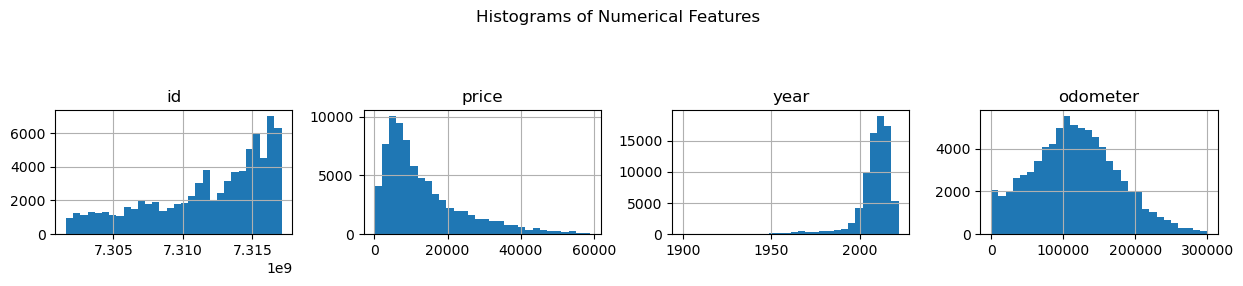


Boxplots for Numerical Features:


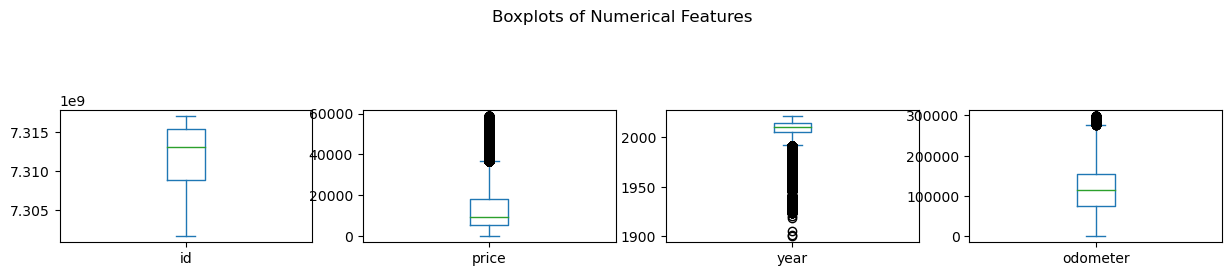

In [5]:
# Histograms for all numerical features
data.hist(bins=30, figsize=(15, 10), layout=(5, 4))  # Adjust layout depending on the number of numerical features
plt.suptitle('Histograms of Numerical Features')
plt.show()

# Boxplots for numerical features to check for outliers
print("\nBoxplots for Numerical Features:")
data.plot(kind='box', subplots=True, layout=(5, 4), figsize=(15, 10), sharex=False, sharey=False)  # Adjust layout
plt.suptitle('Boxplots of Numerical Features')
plt.show()


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [6]:
numerical_features = ['year', 'odometer']
X = data[numerical_features]
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict the price on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 98024874.99423555
R^2 Score: 0.21155398282392646


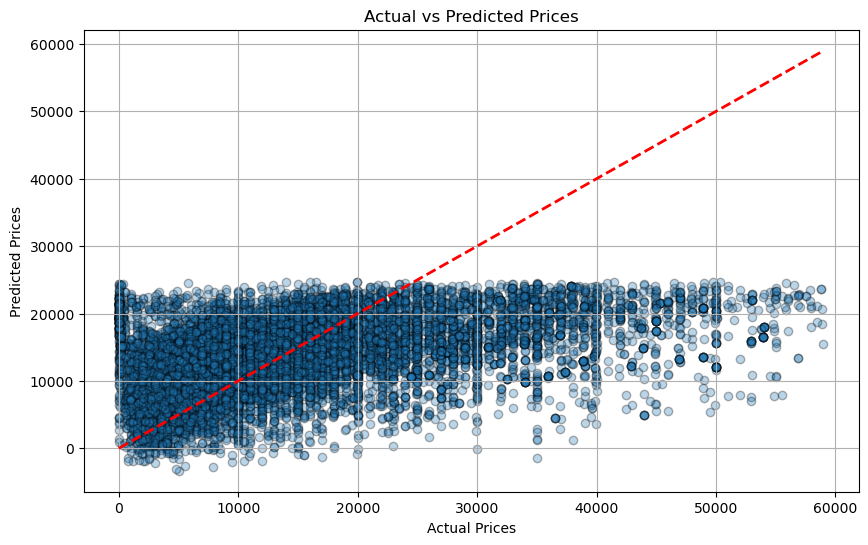

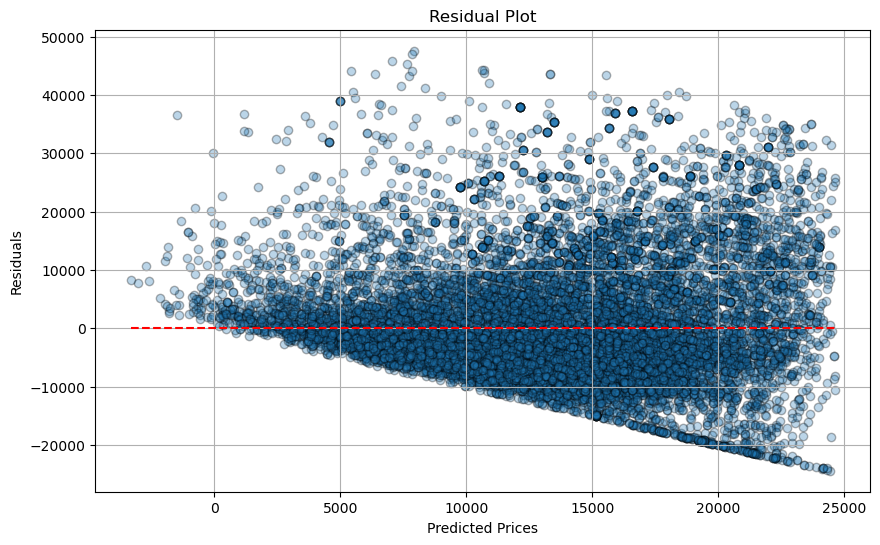

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, edgecolors='k')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.grid(True)

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.3, edgecolors='k')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='--')
plt.grid(True)

In [8]:
categorical_features = ['region', 'model', 'condition', 'cylinders', 'fuel', 
                        'drive', 'size', 'type', 'paint_color', 'state']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_features)
    ])

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

X = data[numerical_features + categorical_features]
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict the price on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 54988865.679955415
R^2 Score: 0.5577066317407646


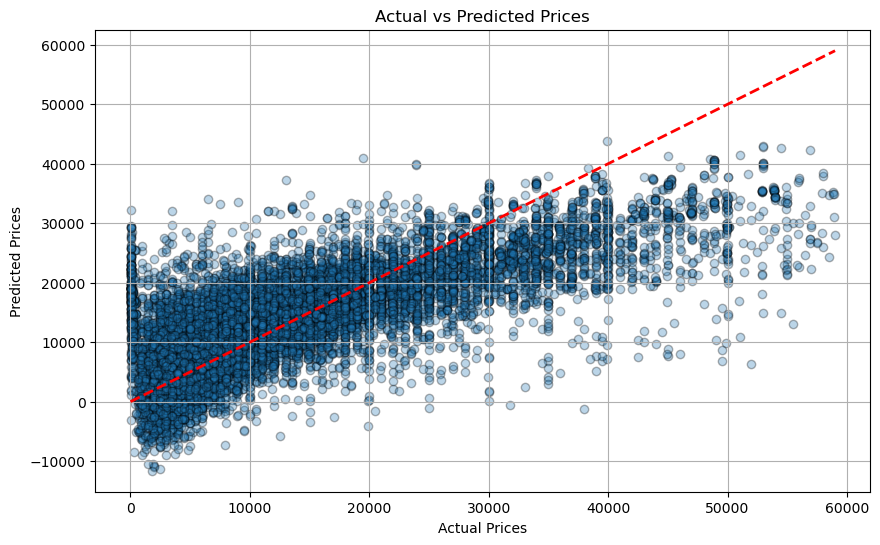

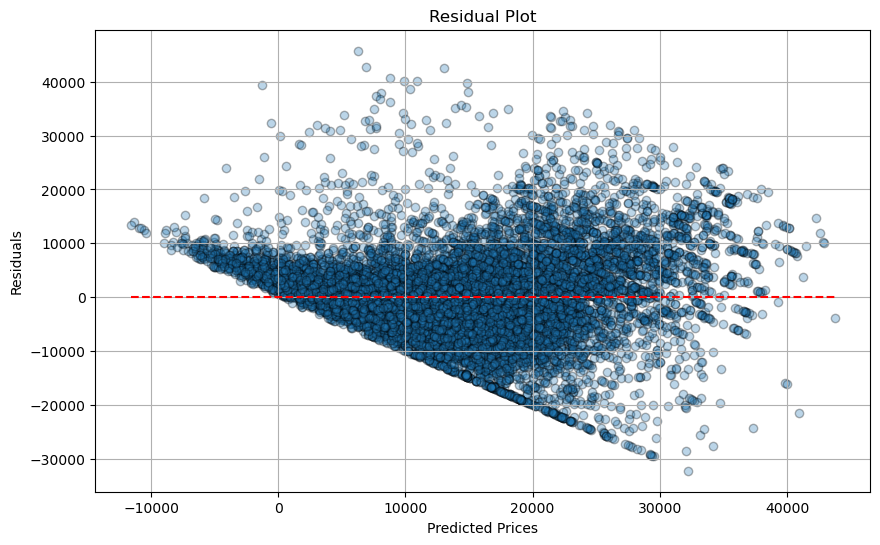

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, edgecolors='k')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.grid(True)

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.3, edgecolors='k')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='--')
plt.grid(True)

In [10]:
# Define the model pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=0))
])

# Splitting data into features and target
X = data[numerical_features + categorical_features]
y = data['price']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-Squared (R2): {r2}")

Model Evaluation Metrics:
Mean Squared Error (MSE): 17043005.390291158
R-Squared (R2): 0.8629175531060292


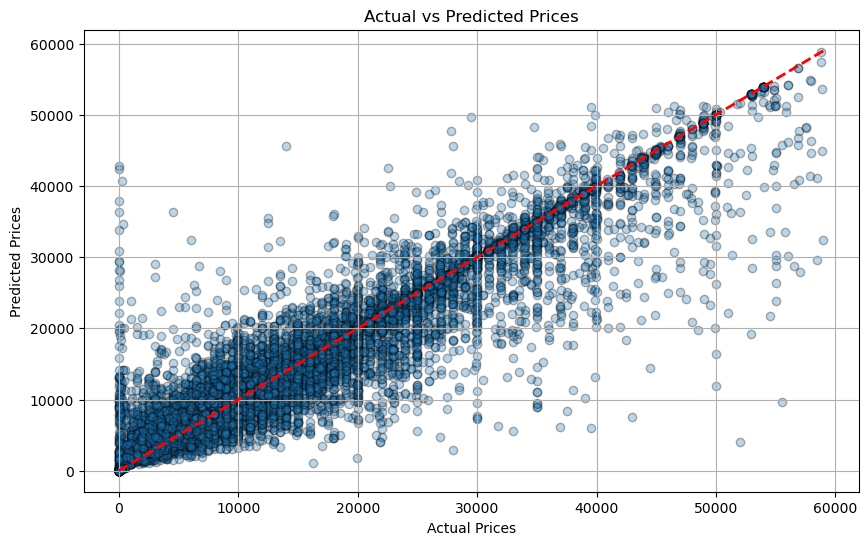

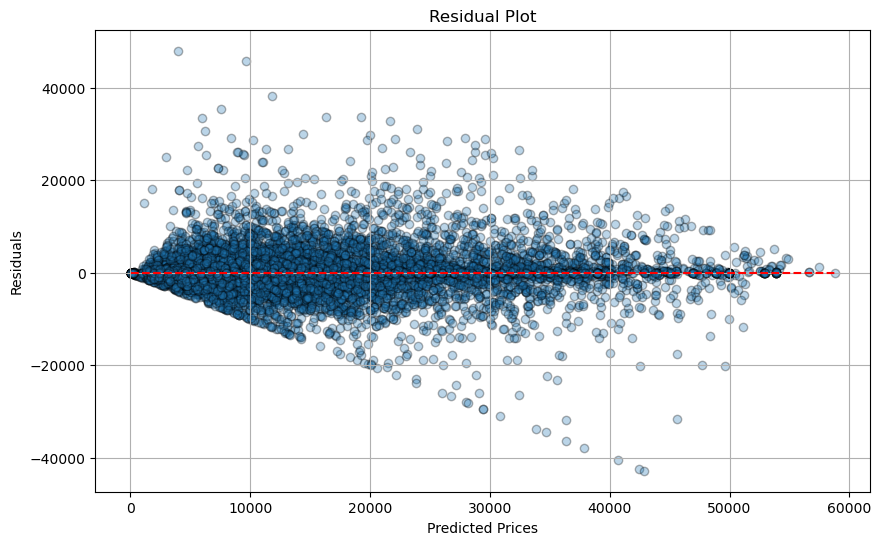

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, edgecolors='k')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.grid(True)

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.3, edgecolors='k')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='--')
plt.grid(True)

plt.show()

In [12]:
# Grid Search

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid = {
    'regressor__n_estimators': [100, 200],  # Number of trees in the forest
    'regressor__max_depth': [10, 20, None],  # Maximum number of levels in trees
    'regressor__min_samples_split': [2, 10],  # Minimum number of samples required to split a node
    'regressor__min_samples_leaf': [1, 4],  # Minimum number of samples required at each leaf node
    'regressor__max_features': ['auto', 'sqrt']  # Number of features to consider when looking for the best split
}

# Grid Search initialization
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the grid search model
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\Shadow\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Shadow\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shadow\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Shadow\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estima

Best parameters: {'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Best score: -23023526.431158304


In [13]:
# Predict using the best model
y_pred = grid_search.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)


Mean Squared Error: 20940511.22238466
R^2 Score: 0.8315686434500327


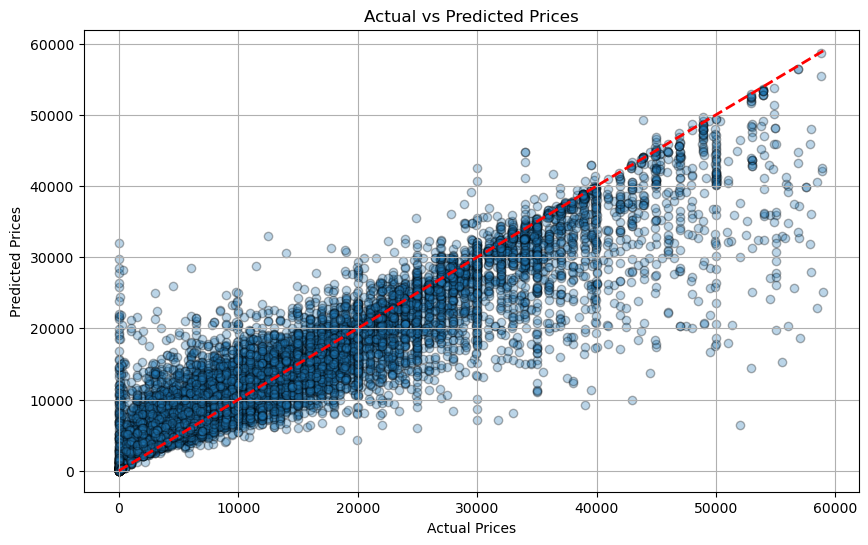

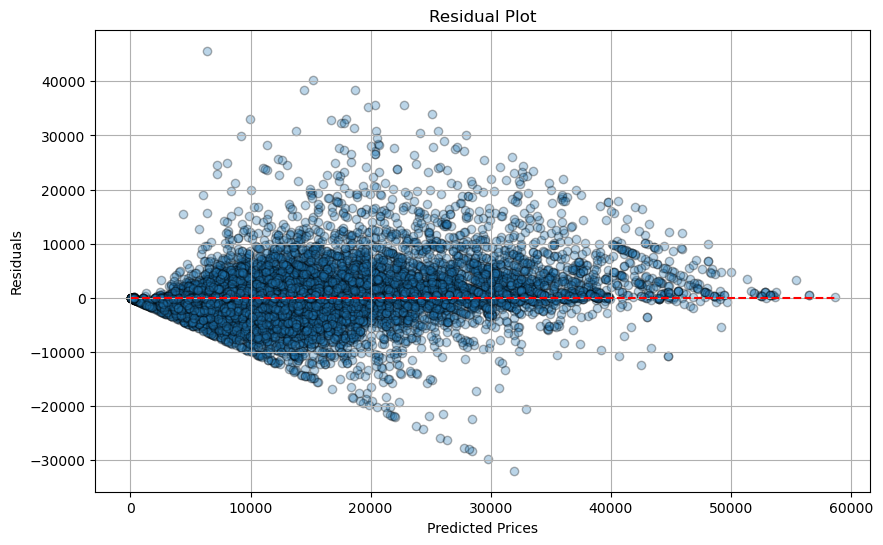

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, edgecolors='k')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.grid(True)

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.3, edgecolors='k')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='--')
plt.grid(True)

plt.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.